In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pudl
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.core.debugger import set_trace
%matplotlib inline

In [3]:
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,4)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56

## Unify `pudl.transform.ferc1` and FERC Plant Classification
FERC Plants as they are in PUDL should be what feeds into ID assignment. Then ID assignment can be appended to the transform.ferc1 process for plants.
 * Change all FERC record_id column names to be table specific
 * Do some visual exploration of the plant + fuel data to see what we've ended up with.
     * Evaluate match between plant_id_pudl and plant_id_ferc1 -- how much disparity is there?
     * Re-do the FERC vs. EIA correlations using 

In [7]:
ferc714_dir = os.path.join(pudl.settings.PUDL_DIR,'data','ferc','form714','form714-database')
hourly_demand_df = pd.read_csv(os.path.join(ferc714_dir, 'Part 3 Schedule 2 - Planning Area Hourly Demand.csv'))

In [11]:
pd.to_datetime(hourly_demand_df.plan_date)

0        2006-01-01
1        2006-01-02
2        2006-01-03
3        2006-01-04
4        2006-01-05
5        2006-01-06
6        2006-01-07
7        2006-01-08
8        2006-01-09
9        2006-01-10
10       2006-01-11
11       2006-01-12
12       2006-01-13
13       2006-01-14
14       2006-01-15
15       2006-01-16
16       2006-01-17
17       2006-01-18
18       2006-01-19
19       2006-01-20
20       2006-01-21
21       2006-01-22
22       2006-01-23
23       2006-01-24
24       2006-01-25
25       2006-01-26
26       2006-01-27
27       2006-01-28
28       2006-01-29
29       2006-01-30
            ...    
514628   2006-12-02
514629   2006-12-03
514630   2006-12-04
514631   2006-12-05
514632   2006-12-06
514633   2006-12-07
514634   2006-12-08
514635   2006-12-09
514636   2006-12-10
514637   2006-12-11
514638   2006-12-12
514639   2006-12-13
514640   2006-12-14
514641   2006-12-15
514642   2006-12-16
514643   2006-12-17
514644   2006-12-18
514645   2006-12-19
514646   2006-12-20


In [4]:
ferc1_raw_dfs = pudl.extract.ferc1.extract(ferc1_tables=['plants_steam_ferc1'])
#set_trace()
ferc1_tfr_dfs = pudl.transform.ferc1.plants_steam(ferc1_raw_dfs, {})

Defining new FERC Form 1 DB based on 2016...
Clearing any existing FERC Form 1 database MetaData...
Extracting tables from FERC 1:
    plants_steam_ferc1...
        Identifying distinct large FERC plants.


/home/zane/anaconda3/envs/pudl/lib/python3.7/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


        Categorized 11177 of 12686 (88.10%) plant records.
        Assigning FERC Plant IDs.
        Found 1122 orphaned plant records.
        Found 1233 non-orphaned plant groups.
        Began with 12686 raw steam plant records.
        Ended with 12591 transformed steam plant records.


In [ ]:
pudl_out = pudl.output.pudltabl.PudlTabl(freq='MS')

In [6]:
plants_steam_ferc1 = pudl_out.plants_steam_ferc1()
fuel_ferc1 = pudl_out.fuel_ferc1()

In [31]:
cols = [
    'report_year',
    'utility_id_ferc1',
    'utility_name_ferc1',
    'plant_id_pudl',
    'plant_id_ferc1',
    'plant_name',
    'plant_type',
    'capacity_mw',
    'construction_type',
    'construction_year',
]

In [67]:
pid = np.random.choice(plants_steam_ferc1.plant_id_ferc1.unique())
plants_steam_ferc1[plants_steam_ferc1.plant_id_ferc1==pid][cols]

,report_year,utility_id_ferc1,utility_name_ferc1,plant_id_pudl,plant_id_ferc1,plant_name,plant_type,capacity_mw,construction_type,construction_year
6112,2008,194,Wisconsin Power and Light Company,121,1567,columbia ii (wpl),steam,236.0,conventional,1978.0


In [69]:
# 32, 846, 979
#plants_steam_ferc1[plants_steam_ferc1.plant_id_ferc1.isin([32,846,979])][cols]

# Many of the orphaned plant records seem to be part of clear time series.
# This is a list of PUDL Plant IDs that contain these good plants, with bad
# FERC Plant ID assignments.

funny_plant_id_pudl = [
    64,
    121,
    302,
    357,
    368,
    420,
    453,
    568,
    613,
    619,
    737,
    1109,
]
plants_steam_ferc1[plants_steam_ferc1.plant_id_pudl==121][cols]

,report_year,utility_id_ferc1,utility_name_ferc1,plant_id_pudl,plant_id_ferc1,plant_name,plant_type,capacity_mw,construction_type,construction_year
3543,2004,89,Madison Gas and Electric Company,121,311,columbia 1,steam,112.60,conventional,1975.0
3544,2005,89,Madison Gas and Electric Company,121,311,columbia 1,steam,112.60,conventional,1975.0
3545,2006,89,Madison Gas and Electric Company,121,311,columbia 1,steam,112.60,conventional,1975.0
3546,2007,89,Madison Gas and Electric Company,121,311,columbia 1,steam,112.60,conventional,1975.0
3547,2008,89,Madison Gas and Electric Company,121,311,columbia 1,steam,112.60,conventional,1975.0
3548,2009,89,Madison Gas and Electric Company,121,311,columbia 1,steam,112.60,conventional,1975.0
3549,2010,89,Madison Gas and Electric Company,121,311,columbia 1,steam,112.60,conventional,1975.0
3550,2011,89,Madison Gas and Electric Company,121,311,columbia 1,steam,112.60,conventional,1975.0
3551,2012,89,Madison Gas and Electric Company,121,311,columbia 1,steam,112.60,conventional,1975.0
3552,2013,89,Madison Gas and Electric Company,121,311,columbia 1,steam,112.60,conventional,1975.0


In [516]:
import glob
def ferc_test_prep():
    ferc1_years = np.arange(2004, 2017)
    # Start with an empty dataframe:
    all_training_groups = pd.DataFrame(columns=ferc1_years.astype(str))
    # Read all the accumulated training groups into one dataframe
    for f in glob.glob('ferc1_plant_training_groups_2018*.csv'):
        all_training_groups = all_training_groups.append(pd.read_csv(f))

    all_training_groups = all_training_groups.drop_duplicates().dropna(thresh=2)
    all_training_groups = all_training_groups.reset_index().drop('index', axis=1)
    all_training_groups.columns = all_training_groups.columns.astype(int)
    all_training_groups = all_training_groups.fillna('')

    # Dump all of the record IDs into a single column.
    X = pd.DataFrame()
    for col in all_training_groups.columns:
        X = pd.concat([X,all_training_groups[col]])
    X = X.replace('',np.nan)
    X = X.dropna().reset_index().drop('index', axis=1)
    X.columns = ['record_id']
    X = pd.merge(X, ferc1_steam_clean)
    
    strmess = pd.Series()
    len(strmess)
    for yr in ferc1_years:
        if(len(strmess)==0):
            strmess = all_training_groups[yr]
        else:
            strmess = strmess + ',' + all_training_groups[yr]

    y = pd.Series()
    for i in X.index:
        y = pd.concat([y, strmess[strmess.str.contains(X['record_id'].iloc[i])]])
    y = y.reset_index()[0]
    return X, y

In [517]:
def explore_params():
    scores = []
    params = np.linspace(0.0, 2.0, num=21)
    for p in params:
        print("Fitting FERC Plant Classifier.")
        ferc_clf = make_ferc_clf(ferc1_steam_clean, plant_name_wt=p, ngram_min=2, ngram_max=10, min_sim=0.75)
        # Best values on transect, with all others set to defaults:
        # plant_name_wt: 1.3 (0.5-1.5)
        # respondent_id_wt: 1.4 (1.0-1.5)
        # tot_capacity_wt: 1.3 (1.0-1.3)
        # plant_kind_wt: 1.3 (1.0-1.3)
        # yr_const_wt: 1.0 (0.8-1.3)
        # type_const_wt: 0.8 (0.8-1.0)
        # ngram_range (2,9)
        # min_sim 0.77
        print("Preparing test.")
        X, y = ferc_test_prep()
        print("Scoring fits.")
        s = ferc_clf.score(X,y)
        print(f"    param: {p}, score: {s}")
        scores = scores + [s]
    return params, scores

%lprun -u 1.0 -f pudl.transform.ferc1.where_matches -f pudl.transform.ferc1.best_matches params, scores = explore_params()

Fitting FERC Plant Classifier.
Preparing test.
Scoring fits.


IndexError: index 0 is out of bounds for axis 0 with size 0

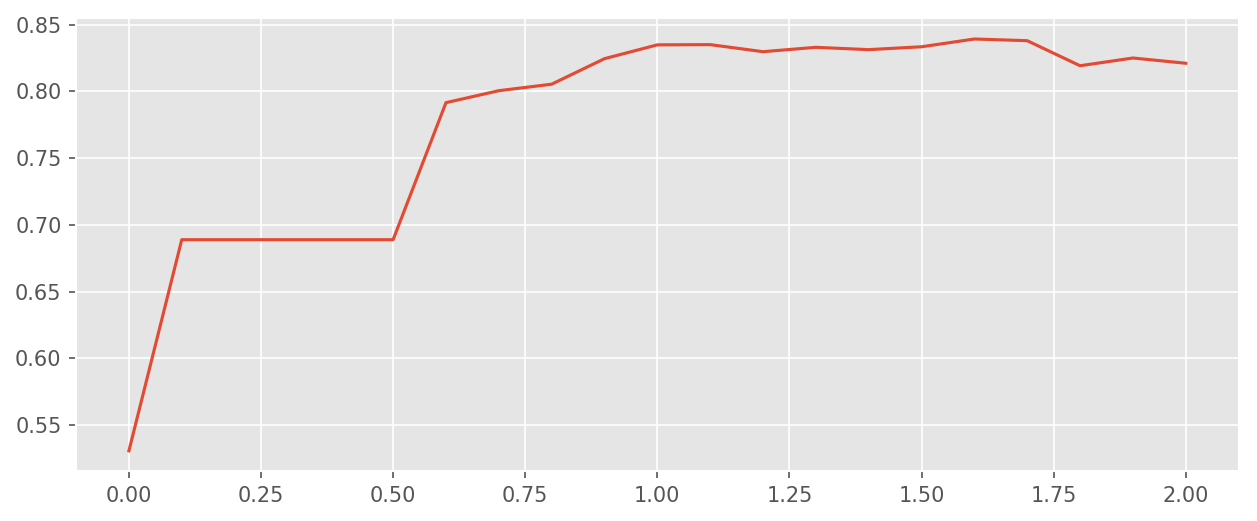

In [9]:
plt.plot(params, scores)

In [16]:
plant_groups = ferc_clf.predict(ferc_clf._best_of.record_id.values)

/home/zane/anaconda3/envs/pudl/lib/python3.7/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


TypeError: object of type 'int' has no len()

In [39]:
plant_group_sizes = [len(plant_groups.loc[i][plant_groups.loc[i] != '']) for i in plant_groups.index]

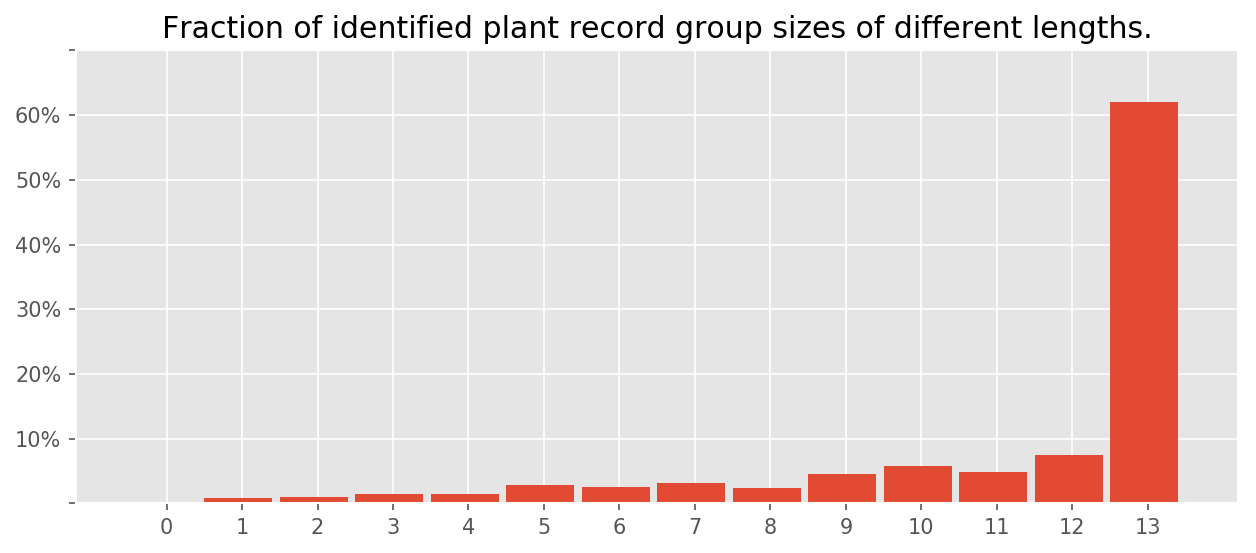

In [40]:
plt.hist(plant_group_sizes, bins=np.arange(-0.5,14.5), density=True, align='mid', width=0.9)
plt.title('Fraction of identified plant record group sizes of different lengths.')
locs, labels = plt.yticks()
plt.yticks(locs, ['','10%', '20%', '30%', '40%', '50%', '60%'])
plt.xticks(np.arange(0,14));

In [10]:
# Create an empty Data Frame in which to collect new interesting training samples
new_training_groups = pd.DataFrame(columns=ferc1_years)
features = [
    'record_id',
    'report_year',
    'respondent_id',
    'plant_name',
    'plant_kind_clean',
    'type_const_clean',
    'tot_capacity',
    'yr_const'
]

In [11]:
# Select a new potential training sample from our dataframe:
n_recs = -1
n_names = 1
n_resp = 1
#while n_recs < 12 or (n_names < 3 and n_resp < 2):
while n_recs < 12 or n_resp < 2:
    random_group = np.random.choice(plant_groups)
    n_recs = len(random_group)
    random_record = ferc1_steam_clean[ferc1_steam_clean.record_id.isin(random_group)]
    n_names = len(random_record['plant_name'].unique())
    n_resp = len(random_record['respondent_id'].unique())

# Inspect the candidate
random_record[features]

KeyboardInterrupt: 

In [12]:
# Poke around a bit and see if the candidate is really complete / appropriate.
#ferc1_steam_clean[
#    (ferc1_steam_clean.plant_name.str.match('.*east bend.*'))
#    #(ferc1_steam_clean.report_year.isin([2016,]))
#    #& (ferc1_steam_clean.respondent_id==120)
#][features]
#ferc1_steam[(ferc1_steam.report_year==2004) & (ferc1_steam.respondent_id==41)]

In [13]:
# If the candidate is good, add it to the accumulation dataframe.
#new_group = pd.merge(
#    pd.DataFrame(ferc1_years, columns=['report_year']),
#    random_record[['report_year', 'record_id']], how='outer'
#).fillna('').set_index('report_year').transpose()
##new_training_groups = new_training_groups.append(new_group).drop_duplicates().reset_index().drop('index', axis=1)
#new_training_groups

In [14]:
# Once we've collected enough new records, save them in a CSV file for later use.
#dtstr = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
#new_training_groups.to_csv(f'ferc1_plant_training_groups_{dtstr}.csv', index=False)

In [262]:
dice = pd.read_csv("~/private/eff_large_wordlist.txt",
                   sep='\t', header=None, names=['rolls', 'words'])
n_words = 6

In [322]:
print(" ".join(dice['words'].sample(n_words)))

phrase exciting barn diaphragm campsite gulp


In [3]:
np.arange(0,15)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [1]:
import pudl

ModuleNotFoundError: No module named 'pudl'